=== Dataset Preview ===
       Tweet ID                                         Tweet Text Country  \
0  2.110407e+17  #Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...      US   
1  2.111117e+17  RT @Jack4Ward: Get in on the fun every Thursda...      US   
2  2.111572e+17  Welcome to our newest STUDENTathlete- Reagan B...      US   
3  2.111626e+17  Denver Post: #Colorado governor signs bill cre...      US   
4  2.112170e+17  Pretty sure I'm going to live in Manitou Sprin...      US   

  Category    Sub-Category      Type  Crisis date  
0  Natural  Climatological  Wildfire         2012  
1  Natural  Climatological  Wildfire         2012  
2  Natural  Climatological  Wildfire         2012  
3  Natural  Climatological  Wildfire         2012  
4  Natural  Climatological  Wildfire         2012   

=== Original vs. Cleaned Tweet Preview ===
                                               Tweet  \
0  #Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...   
1  RT @Jack4Ward: Get in on the fun ev

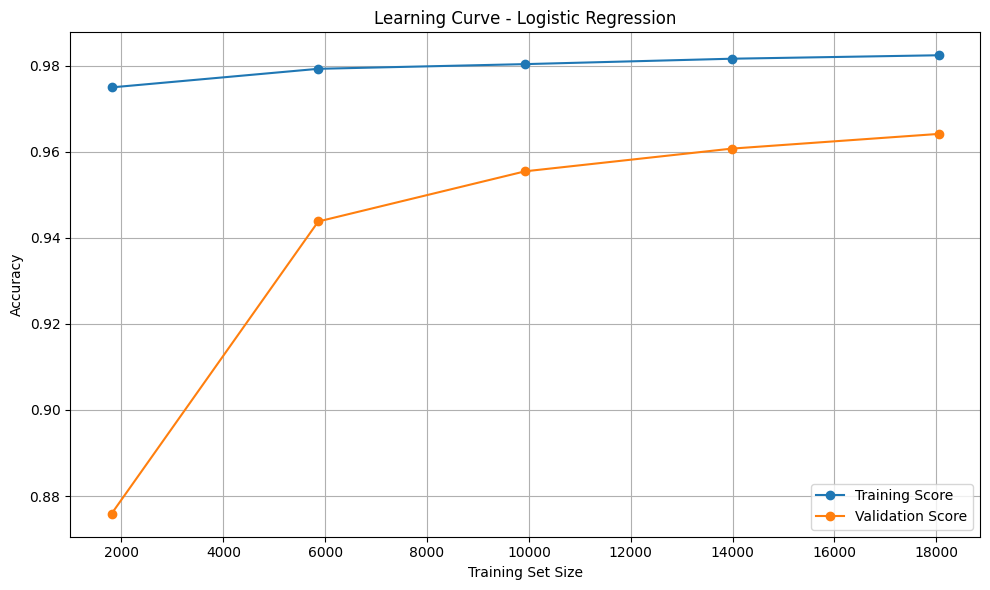


=== Generating Learning Curve for Random Forest ===
Train size: 1804
  Mean Training Accuracy   : 0.9993
  Mean Validation Accuracy : 0.9157
--------------------------------------------------
Train size: 5864
  Mean Training Accuracy   : 0.9995
  Mean Validation Accuracy : 0.9474
--------------------------------------------------
Train size: 9925
  Mean Training Accuracy   : 0.9996
  Mean Validation Accuracy : 0.9562
--------------------------------------------------
Train size: 13985
  Mean Training Accuracy   : 0.9996
  Mean Validation Accuracy : 0.9605
--------------------------------------------------
Train size: 18046
  Mean Training Accuracy   : 0.9995
  Mean Validation Accuracy : 0.9633
--------------------------------------------------


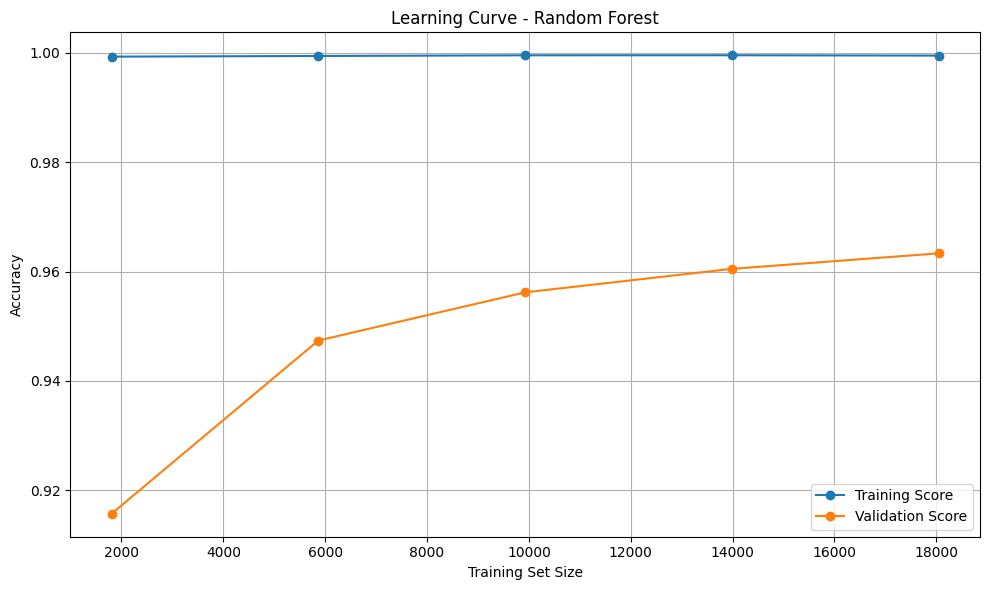


=== Evaluation: Logistic Regression ===

📊 Training Classification Report:
                             precision    recall  f1-score   support

 Human-induced - Accidental       0.99      1.00      1.00      5845
Human-induced - Intentional       1.00      0.99      0.99      1422
             Mixed - Others       1.00      0.83      0.91       969
   Natural - Climatological       0.99      0.99      0.99      2057
      Natural - Geophysical       0.99      0.99      0.99      3653
     Natural - Hydrological       0.97      0.99      0.98      4824
   Natural - Meteorological       0.96      0.99      0.97      2779
           Natural - Others       1.00      0.93      0.96      1009

                   accuracy                           0.98     22558
                  macro avg       0.99      0.96      0.97     22558
               weighted avg       0.98      0.98      0.98     22558


📊 Testing Classification Report:
                             precision    recall  f1-score 

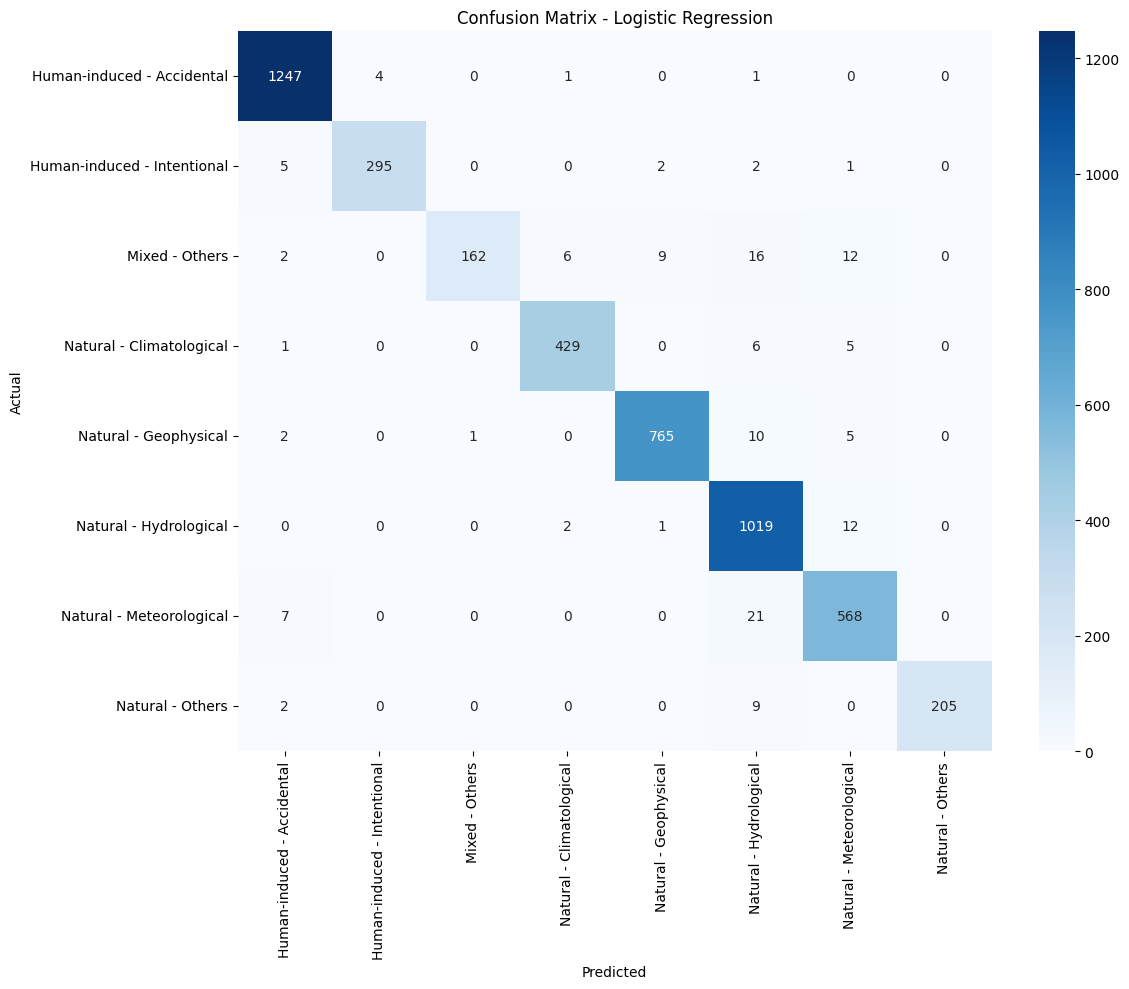

✅ Training Accuracy: 0.9832
✅ Testing Accuracy:  0.9700

=== Evaluation: Random Forest ===

📊 Training Classification Report:
                             precision    recall  f1-score   support

 Human-induced - Accidental       1.00      1.00      1.00      5845
Human-induced - Intentional       1.00      1.00      1.00      1422
             Mixed - Others       1.00      1.00      1.00       969
   Natural - Climatological       1.00      1.00      1.00      2057
      Natural - Geophysical       1.00      1.00      1.00      3653
     Natural - Hydrological       1.00      1.00      1.00      4824
   Natural - Meteorological       1.00      1.00      1.00      2779
           Natural - Others       0.99      1.00      1.00      1009

                   accuracy                           1.00     22558
                  macro avg       1.00      1.00      1.00     22558
               weighted avg       1.00      1.00      1.00     22558


📊 Testing Classification Report:
         

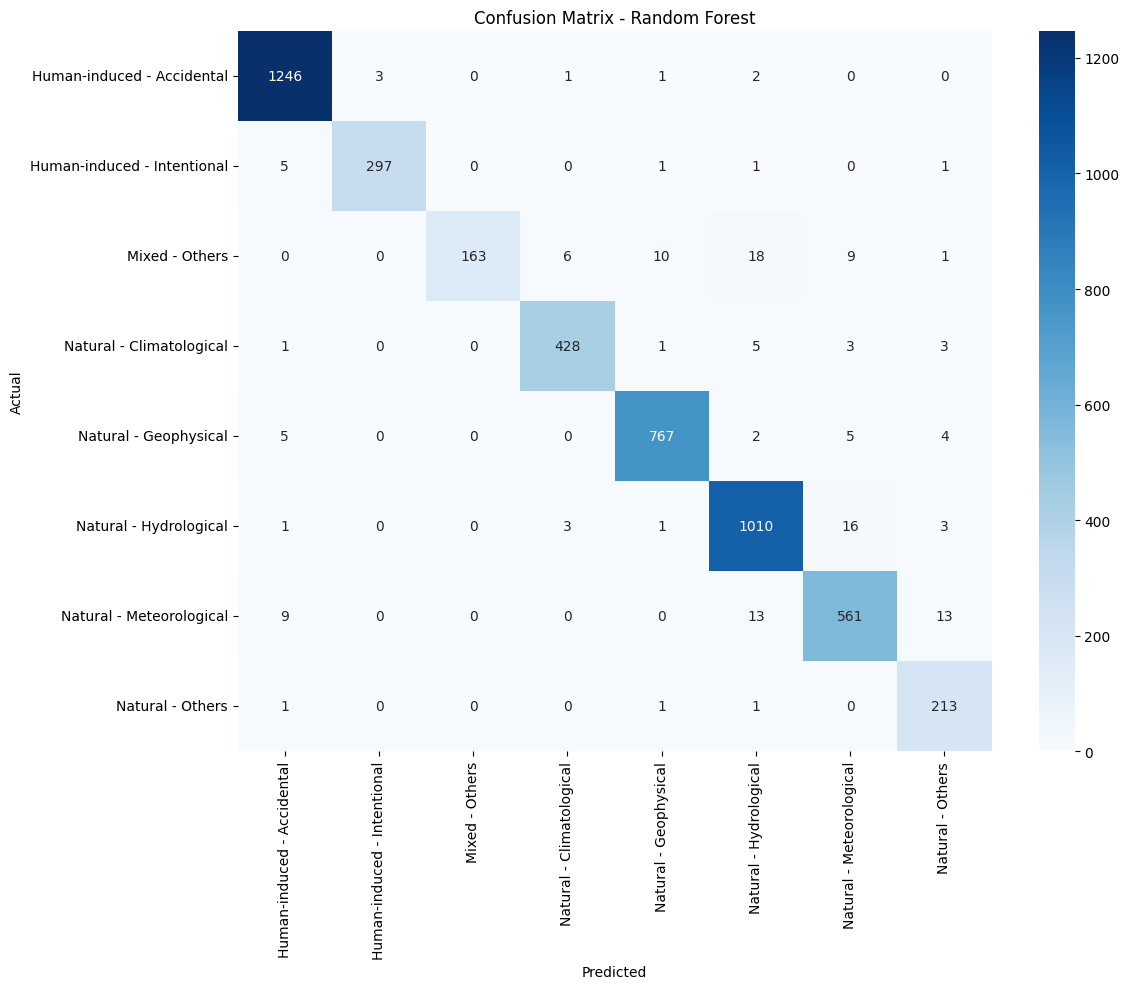

✅ Training Accuracy: 0.9995
✅ Testing Accuracy:  0.9690


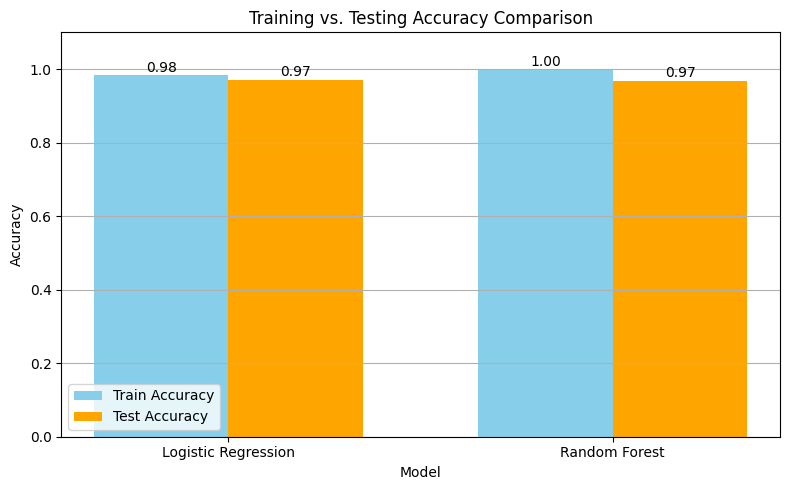

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Step 1: Load Dataset
file_path = 'Combined_Tweet_Dataset_Sorted.csv'
data = pd.read_csv(file_path)
print("=== Dataset Preview ===")
print(data.head(), "\n")

# Step 2: Preprocessing
# Fix column name by stripping extra spaces
data['Tweet'] = data['Tweet Text'].astype(str)

# Define cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)       # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)           # Remove punctuation and numbers
    text = text.lower().strip()                       # Lowercase and remove leading/trailing spaces
    return text

# Apply cleaning
data['Clean_Tweet'] = data['Tweet'].apply(clean_text)

# Print preview of before vs after cleaning
print("=== Original vs. Cleaned Tweet Preview ===")
print(data[['Tweet', 'Clean_Tweet']].head(10))


# Step 3: Prepare Features and Labels
# Drop rows where Category or Sub-Category is NaN to prevent errors
data.dropna(subset=['Category', 'Sub-Category'], inplace=True)
X = data['Clean_Tweet']
y = data['Category'] + " - " + data['Sub-Category']

# Preview output
print("=== Features and Labels Preview ===")
for i in range(10):  # You can change 5 to show more rows
    print(f"TWEET {i+1}:")
    print(f"  Cleaned Text : {X.iloc[i]}")
    print(f"  Label        : {y.iloc[i]}")
    print("-" * 60)

# Step 4: Train-Validation-Test Split

from sklearn.model_selection import train_test_split

# Step 4: Train-Validation-Test Split

# First, split into 70% train and 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Fix: Remove classes with <2 examples in y_temp
label_counts = y_temp.value_counts()
valid_labels = label_counts[label_counts >= 2].index

X_temp_filtered = X_temp[y_temp.isin(valid_labels)]
y_temp_filtered = y_temp[y_temp.isin(valid_labels)]

# Then split that 30% equally into validation and test → 15% each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp_filtered, y_temp_filtered, test_size=0.5, stratify=y_temp_filtered, random_state=42)

# Print total and individual split sizes
total_samples = len(data)
print("=== Dataset Split Summary ===")
print(f"Total examples       : {total_samples}")
print(f"Training set size    : {len(X_train)}")
print(f"Validation set size  : {len(X_val)}")
print(f"Test set size        : {len(X_test)}")

# Step 5: Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# ✅ Print preview of TF-IDF features
print("=== TF-IDF Feature Matrix Preview (Train Set) ===")
print(f"Shape: {X_train_vec.shape}")  # Rows = documents, Columns = features/words

# Step 6A: Train Logistic Regression Model
import time

print("\n=== Training Logistic Regression Model ===")
print(f"Training data shape: {X_train_vec.shape}")
log_model = LogisticRegression(max_iter=1000, random_state=42)

start = time.time()
log_model.fit(X_train_vec, y_train)
end = time.time()

print("Logistic Regression training complete.")
print(f"Training time: {end - start:.2f} seconds")

# Step 6B: Train Random Forest Model

print("\n=== Training Random Forest Model ===")
print(f"Training data shape: {X_train_vec.shape}")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

start = time.time()
rf_model.fit(X_train_vec, y_train)
end = time.time()

print("Random Forest training complete.")
print(f"Training time: {end - start:.2f} seconds")

# Step 7: Learning Curve Function
def plot_learning_curve(model, X, y, title):
    print(f"\n=== Generating Learning Curve for {title} ===")

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # ✅ Print the sizes and scores
    for i in range(len(train_sizes)):
        print(f"Train size: {train_sizes[i]}")
        print(f"  Mean Training Accuracy   : {train_mean[i]:.4f}")
        print(f"  Mean Validation Accuracy : {test_mean[i]:.4f}")
        print("-" * 50)

    # ✅ Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', label='Validation Score')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(log_model, X_train_vec, y_train, "Logistic Regression")
plot_learning_curve(rf_model, X_train_vec, y_train, "Random Forest")

# Step 8: Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n=== Evaluation: {model_name} ===")

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Classification Reports
    print("\n📊 Training Classification Report:")
    print(classification_report(y_train, y_train_pred, zero_division=0))

    print("\n📊 Testing Classification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    # Confusion Matrix
    print("\n📌 Confusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"✅ Training Accuracy: {train_acc:.4f}")
    print(f"✅ Testing Accuracy:  {test_acc:.4f}")

    return train_acc, test_acc

# Step 9: Evaluate Both Models
log_train_acc, log_test_acc = evaluate_model(
    log_model, X_train_vec, X_test_vec, y_train, y_test, "Logistic Regression")

rf_train_acc, rf_test_acc = evaluate_model(
    rf_model, X_train_vec, X_test_vec, y_train, y_test, "Random Forest")

# Step 10: Accuracy Comparison Chart

import matplotlib.pyplot as plt
import numpy as np

# Labels and accuracy values from evaluation step
models = ['Logistic Regression', 'Random Forest']
train_accuracies = [log_train_acc, rf_train_acc]
test_accuracies = [log_test_acc, rf_test_acc]

# Plot settings
x = np.arange(len(models))
bar_width = 0.35

# Create the bar chart
plt.figure(figsize=(8, 5))
bars1 = plt.bar(x, train_accuracies, width=bar_width, label='Train Accuracy', color='skyblue')
bars2 = plt.bar(x + bar_width, test_accuracies, width=bar_width, label='Test Accuracy', color='orange')

# Add value labels on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=10)

# Axis and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training vs. Testing Accuracy Comparison')
plt.xticks(x + bar_width / 2, models)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()